# Environmental Sound Classification

---
[Mattia Pujatti](mattia.pujatti.1@studenti.unipd.it), ID 1232236, master degree in Physics of Data

---

This notebook has been realized as final project for the course of Human Data Analytics, held by professors [Michele Rossi](rossi@dei.unipd.it) and [Francesca Meneghello](meneghello@dei.unipd.it), during the academic year 2019/2020 at the University of Padua.

#### [Introduction](#Introduction) | [Dataset](#The-Dataset) | [Audio Features](#Audio-Features) | [Example of Analysis](#Example) | [Dataset Construction](#Dataset-Construction)

## Introduction

*The main purpose of this notebook will be to provide an efficient way, using machine learning techniques, to classify environmental sound clips belonging to one of the only public available dataset on the internet. <br>
Several approaches have been tested during the years, but only a few of them were able to reproduce or even overcome the human classification accuracy, that was estimated around 81.30%. <br>
The analysis will be organized in the following way: since the very first approaches were maily focused on the examination of audio features that one could extract from raw audio files, we will provide a way to collect and organize all those "vector of features" and use them to distinguish among different classes. Then, different classification architectures and techniques will be implemented and compared among each other, in order also to show how they react to different data manipulation (overfitting, numerical stability,...). <br>
In the end, it will be shown that all those feature classifiers, without exceptions, underperform when compared to the results provided by the use of Convolutional Neural Networks directly on audio signals and relative spectrograms (so without any kind of feature extraction), and how this new approach opened for a large number of opportunities in term of models with high accuracy in sound classification.*

Most of the audio features that we are interested about for our classifier will be extracted from those clips exploiting the powerful and complete functions provided by the library [librosa](https://librosa.org/doc/latest/index.html), for Python.

In [218]:
# Requirements
import os
from tqdm.notebook import tqdm
import requests
import zipfile
import pydub
import numpy as np
import IPython
import matplotlib.pyplot as plt
import librosa
import librosa.display
import pandas as pd
import seaborn as sns
from matplotlib.gridspec import GridSpec
import re
import warnings

sns.set_theme()
warnings.filterwarnings('ignore')

## The Dataset

One of the main obstacle in research activities focused on environmental sound classification was the scarcity of large public datasets to exploit to train our networks. Luckily, a few years ago, thank to the work of Karol J. Piczak, form the University of Warsav, a set of 2000 recordings from the **[Freesound.org project](http://freesound.org/)**, representing 50 classes of various common sounds, were collected and correctly labeled, forming one the first accessible dataset for this kind of problems. A large number of papers have been written in the last years, each of them proposing a new and more efficient approach to classify those kind of clips, even surpassing the human classification accuracy. In this notebook we will try to do the same: first analyzing some of the audio features that we can extract from the tracks, that can be used to distinguish among various classes, and then implementing a multivariate analysis technique, like neural networks. 

The **ESC-50 dataset** is a labeled collection of 2000 environmental audio recordings suitable for benchmarking methods of environmental sound classification.

The dataset consists of 5-second-long recordings organized into 50 semantical classes (with 40 examples per class) loosely arranged into 5 major categories:

| <sub>Animals</sub> | <sub>Natural soundscapes & water sounds </sub> | <sub>Human, non-speech sounds</sub> | <sub>Interior/domestic sounds</sub> | <sub>Exterior/urban noises</sub> |
| :--- | :--- | :--- | :--- | :--- |
| <sub>Dog</sub> | <sub>Rain</sub> | <sub>Crying baby</sub> | <sub>Door knock</sub> | <sub>Helicopter</sub></sub> |
| <sub>Rooster</sub> | <sub>Sea waves</sub> | <sub>Sneezing</sub> | <sub>Mouse click</sub> | <sub>Chainsaw</sub> |
| <sub>Pig</sub> | <sub>Crackling fire</sub> | <sub>Clapping</sub> | <sub>Keyboard typing</sub> | <sub>Siren</sub> |
| <sub>Cow</sub> | <sub>Crickets</sub> | <sub>Breathing</sub> | <sub>Door, wood creaks</sub> | <sub>Car horn</sub> |
| <sub>Frog</sub> | <sub>Chirping birds</sub> | <sub>Coughing</sub> | <sub>Can opening</sub> | <sub>Engine</sub> |
| <sub>Cat</sub> | <sub>Water drops</sub> | <sub>Footsteps</sub> | <sub>Washing machine</sub> | <sub>Train</sub> |
| <sub>Hen</sub> | <sub>Wind</sub> | <sub>Laughing</sub> | <sub>Vacuum cleaner</sub> | <sub>Church bells</sub> |
| <sub>Insects (flying)</sub> | <sub>Pouring water</sub> | <sub>Brushing teeth</sub> | <sub>Clock alarm</sub> | <sub>Airplane</sub> |
| <sub>Sheep</sub> | <sub>Toilet flush</sub> | <sub>Snoring</sub> | <sub>Clock tick</sub> | <sub>Fireworks</sub> |
| <sub>Crow</sub> | <sub>Thunderstorm</sub> | <sub>Drinking, sipping</sub> | <sub>Glass breaking</sub> | <sub>Hand saw</sub> |

Clips in this dataset have been manually extracted from public field recordings gathered by the **[Freesound.org project](http://freesound.org/)**. The dataset has been prearranged into 5 folds for comparable cross-validation, making sure that fragments from the same original source file are contained in a single fold.

---

Directory content:

- `audio/*.wav`

  2000 audio recordings in WAV format (5 seconds, 44.1 kHz, mono) with the following naming convention:
  
  `{FOLD}-{CLIP_ID}-{TAKE}-{TARGET}.wav`
  
  - `{FOLD}` - index of the cross-validation fold,
  - `{CLIP_ID}` - ID of the original Freesound clip,
  - `{TAKE}` - letter disambiguating between different fragments from the same Freesound clip,
  - `{TARGET}` - class in numeric format [0, 49].

- `meta/esc50.csv`

  CSV file with the following structure containing the labels of the clips:
  
  | <sub>filename</sub> | <sub>fold</sub> | <sub>target</sub> | <sub>category</sub> | <sub>esc10</sub> | <sub>src_file</sub> | <sub>take</sub> |
  | :--- | :--- | :--- | :--- | :--- | :--- | :--- |
  
  The `esc10` column indicates if a given file belongs to the *ESC-10* subset (another version of this dataset with 10 selected classes). 

---

A more thorough description of the dataset is available in the original [paper](http://karol.piczak.com/papers/Piczak2015-ESC-Dataset.pdf) , while the main folder of the project can be found on [github](https://github.com/karolpiczak/ESC-50).

Let's check if the dataset has already been downloaded and is present in the working directory: if not, the zip file available [here](https://github.com/karolpiczak/ESC-50/rchive/master.zip) will be downloaded and extracted in a folder named "ESC-50-master". If the zip file is already present, then it is extracted as well if the folder does not exists yet.

In [2]:
direct_download_link = "https://github.com/karoldvl/ESC-50/archive/master.zip"

In [3]:
def get_data(url):
    """ Download the zip datafile from the direct download link, generating the folder containing the audio files,
    the metadata and some old analysis. The function checks first if the file already exists, and if it is 
    of the correct dimension, if not, it will be deleted and re-downloaded. If the zip file is already present 
    but not extracted, il will be. (If running in colab, you cannot use requests, and so you need to upload 
    manually the zip file). """
    
    zipfilename = 'ESC-50-master.zip'
    dirname = 'ESC-50-master'

    # Check the dimension of the file
    
    # Many times apparently the connection is not complete, so we repeat until success
    total_size = None
    attempt = 1
    while total_size==None:
        try:         # connect
            print("Trying to connect... attempt ", attempt)
            response = requests.get(url, stream=True)
            total_size = int(response.headers.get('Content-Length')) # in bytes
        except:
            attempt += 1
            response.close()
    
    if (abs(os.path.getsize(zipfilename) - total_size) > 1024*1024): # checking the difference to be at most 1MB
        os.remove(zipfilename)
    # Check if the data folder already exists
    if not os.path.exists(dirname):
        # Check if the zip file has already been downloaded
        if not os.path.exists(zipfilename):
            # Download the file from the direct link reported above
            with open(zipfilename, 'wb') as f: 
                with tqdm(total=total_size, unit='B', unit_scale=True, unit_divisor=1024, 
                          desc='Downloading the file...') as pbar:        
                    for data in response.iter_content(32*1024):            
                        f.write(data)
                        pbar.update(len(data))
        # Unzip the file
        with zipfile.ZipFile(zipfilename) as zf:
            for member in tqdm(zf.infolist(), desc='Unzipping the file...'):
                try:
                    zf.extract(member, dirname)
                except zipfile.error as e:
                    pass        
    response.close()

In [4]:
# Download or extract the dataset
get_data(direct_download_link)

# In the folder just downloaded there is a sub-directory "audio" that contains 
# all the audio file that we are going to analyze.
audio_dir = os.getcwd() + '/ESC-50-master' + '/ESC-50-master' + '/audio/'

Trying to connect... attempt  1
Trying to connect... attempt  2
Trying to connect... attempt  3
Trying to connect... attempt  4
Trying to connect... attempt  5
Trying to connect... attempt  6
Trying to connect... attempt  7
Trying to connect... attempt  8
Trying to connect... attempt  9
Trying to connect... attempt  10
Trying to connect... attempt  11
Trying to connect... attempt  12
Trying to connect... attempt  13
Trying to connect... attempt  14
Trying to connect... attempt  15
Trying to connect... attempt  16
Trying to connect... attempt  17
Trying to connect... attempt  18
Trying to connect... attempt  19
Trying to connect... attempt  20
Trying to connect... attempt  21
Trying to connect... attempt  22
Trying to connect... attempt  23
Trying to connect... attempt  24
Trying to connect... attempt  25
Trying to connect... attempt  26
Trying to connect... attempt  27
Trying to connect... attempt  28
Trying to connect... attempt  29
Trying to connect... attempt  30
Trying to connect..

In [5]:
# Since the labels are represented by a numerical class in [0-49], it would be nice to have a way to
# associate the name of the class to the label.
label_map = {}
label_df = pd.read_csv(os.getcwd()+'/ESC-50-master/ESC-50-master/meta/esc50.csv')
for i in range(50):
    label_map[i] = label_df.loc[label_df["target"]==i, "category"].unique()[0]

In [6]:
# And the same approach can be useful to distinguish among different macro-categories
# Each macro-category corresponds to a range of "target" parameters among the labels
def macro_categories_map(label):
    if label in [i for i in range(10)]   : return 'Animals' 
    if label in [i for i in range(10,20)]: return 'Natural soundscapes and water sounds'
    if label in [i for i in range(20,30)]: return 'Human, non-speech sounds'  
    if label in [i for i in range(30,40)]: return 'Interior/domestic sounds'
    if label in [i for i in range(40,50)]: return 'Exterior/urban noises'   
    else:
        print("Invalid label input")
        return None

## Audio Features

Next, we will define a class in order to handle and manipulate audio files: this class will contain all the necessary information to completely identify and analyze a single clip, with a trick that avoid keeping in memory the entire signal. Moreover, it will provide a set of functions, mainly coming from _librosa_, to extract features that could be useful in the final classification. Then, once we have chosen the classification method, we are free to select the subset of features to compute those that appear to be more relevant.

This is the internal structure of the class `Clip`:
- `Class Audio`: the subclass that effectively store the audio track, cutting or padding it with zeros if it is not 5.0s long, and with two functions `__enter__` and `__exit__` that allow for a more efficient memory handling, keeping the raw clip only the time necessary to extract its features;
- `__init__`: the constructor of the main Clip class, it takes in input the path of the clip we are analyzing and the corresponding label;
- `Play`: plays the audio in the clip;
- `DisplayWave`: plot the raw signal stored in the clip;
- `DisplaySpectrogram`: plot the spectrogram of the raw signal stored in the clip;

The available features that can be computed are the following:

- `spectral centroids`: the spectral centroid indicates at which frequency the energy of a spectrum is centered upon or, in other words, it indicates where the "center of mass" for a sound is located;
- `spectral roll off`: it is a measure of the shape of the signal, and represents the frequency at which high frequencies decline to 0;
- `spectral bandwidth`:  is defined as the width of the band of light at one-half the peak maximum (or full width at half maximum [FWHM]) and represents the portion of the spectrum which contains most of the energy of the signal;
- `zero-crossing rate`: is the rate at which a signal changes from positive to zero to negative or from negative to zero to positive;
- `mfcc`: the Mel-Frequency-Cepstral-Coefficient of a signal are a small set of features (usually about 10–20) which concisely describe the overall shape of a spectral envelope modeling the characteristics of the human voice (according to the Mel scale);
- `chromagram`: is typically a 12-element feature vector indicating how much energy of each pitch class, {C, C#, D, D#, E, …, B}, is present in the signal (in short, it provides a way to describe a similarities measure between music pieces);
- `delta`: set of coefficients defined as the local derivatives of the mfcc coefficients;
- `delta-delta`: set of coefficients defined as the local derivatives of the delta coefficients, and so the second derivative of the MFCCs;
- `energy`: root-mean-square-energy (RMSE) value for each frame;
- `delta-energy`: delta values of the log-energy for each frame;
- `delta-delta-energy`: delta values of the delta values of the log-energy for each frame.

In [7]:
class Clip():
    """A class to handle those 5.0 seconds clips and extract features from them."""
    
    class Audio:
        """ The actual audio data of the clip.
            Uses a context manager to load/unload the raw audio data. This way clips
            can be processed sequentially with reasonable memory usage, keeping just the 
            features computed but not the entire sound vector.
        """
        
        def __init__(self, path):
            self.path = path
            self.timelength = 5.0
        
        def __enter__(self):
            # In order to prevent having clips longer or smaller than 5 seconds
            self.data, self.rate = librosa.load(self.path, sr=None, duration=self.timelength)
            rawaudiosize = self.timelength*self.rate
            if self.data.shape[0] < rawaudiosize:
                self.raw = np.pad(self.data, pad_width=(0,rawaudiosize-len(self.data)), 
                                   mode='constant', constant_values=0.)
            else:
                self.raw = self.data
                
            return self
        
        def __exit__(self, exception_type, exception_value, traceback):
            if exception_type is not None:
                print(exception_type, exception_value, traceback)
            del self.data
            del self.raw
            
            
            
    def __init__(self, path, label_map):
        self.clipname = os.path.basename(path)
        self.path = path
        
        self.fold = int(self.clipname.split('-')[0])
        self.clipID = int(self.clipname.split('-')[1])
        self.take = self.clipname.split('-')[2]
        self.target = int(self.clipname.split('-')[3].split('.')[0])
        self.category = label_map[self.target]
        
        self.audio = Clip.Audio(self.path)
        

    def Compute_Features(self, features_list=[]):
        """ Exploit the functions provided by the librosa library to compute several audio analysis
        features. Available:
        * spectral centroid, spectral rolloff, spectral bandwidth
        * zero-crossing rate
        * mfcc
        * chromagram
        * delta, delta-delta
        * log-energy, delta-log-energy, delta-delta-log-energy
        If the input values is "all" -> compute all the features listed above
        """
        if features_list == "all": 
            features_list = ["spectral centroid", "spectral rolloff", "spectral bandwidth", 
                             "zero-crossing rate", "mfcc", "chromagram", "delta", "delta-delta", 
                             "energy", "delta-energy", "delta-delta-energy"]
        self.features = {}
        
        with self.audio as audio:
            if "spectral centroid" in features_list:
                self._compute_spectral_centroid(audio.raw, audio.rate)
            if "spectral rolloff" in features_list:
                self._compute_spectral_rolloff(audio.raw, audio.rate)
            if "spectral bandwidth" in features_list:
                self._compute_spectral_bandwidth(audio.raw, audio.rate)
            if "zero-crossing rate" in features_list:
                self._compute_zero_crossing_rate(audio.raw)
            if "mfcc" in features_list:
                self._compute_mfcc(audio.raw, audio.rate)
            if "chromagram" in features_list:
                self._compute_chromagram(audio.raw, audio.rate)
            if "delta" in features_list:
                self._compute_delta(self.audio.raw, audio.rate)
            if "delta-delta" in features_list:
                self._compute_delta_delta(audio.raw, audio.rate)
            if "energy" in features_list:
                self._compute_energy(audio.raw)
            if "delta-energy" in features_list:
                self._compute_delta_energy(audio.raw)
            if "delta-delta-energy" in features_list:
                self._compute_delta_delta_energy(audio.raw)
        return 
    
    def _compute_spectral_centroid(self, audio_track, audio_rate):
        """ The spectral centroid indicates at which frequency the energy of a spectrum is centered 
        upon or, in other words, it indicates where the "center of mass" for a sound is located.
        NFRAMES = (clip_length * frame_rate)/ frame_size 
        Since the frame size = 512 samples by default, for those clips NFRAMES = 431."""
        
        if "spectral centroid" not in self.features: 
            self.features["spectral centroid"] = librosa.feature.spectral_centroid(audio_track, sr=audio_rate)[0]            
        return self.features["spectral centroid"]
    
    def _compute_spectral_rolloff(self, audio_track, audio_rate):
        """The spectral roll off is a measure of the shape of the signal. It represents the frequency 
        at which high frequencies decline to 0. 
        Return a vector with size NFRAMES = 431."""
        
        if "spectral rolloff" not in self.features: 
            self.features["spectral rolloff"] = librosa.feature.spectral_rolloff(audio_track, sr=audio_rate)[0]            
        return self.features["spectral rolloff"]
    
    def _compute_spectral_bandwidth(self, audio_track, audio_rate):
        """The bandwidth is defined as the width of the band of light at one-half the peak maximum 
        (or full width at half maximum [FWHM]) and represents the portion of the spectrum which contains 
        most of the energy of the signal.
        Return a vector of size NFRAMES = 431."""
        
        if "spectral bandwidth" not in self.features: 
            self.features["spectral bandwidth"] = librosa.feature.spectral_bandwidth(audio_track, sr=audio_rate, p=2)[0]            
        return self.features["spectral bandwidth"]
    
    def _compute_zero_crossing_rate(self, audio_track):
        """The zero-crossing rate is the rate at which a signal changes from positive to zero to negative 
        or from negative to zero to positive.
        Return a vector of size NFRAMES = 431."""
        
        if "zero-crossing rate" not in self.features: 
            self.features["zero-crossing rate"] = librosa.feature.zero_crossing_rate(audio_track, pad=False)
        return self.features["zero-crossing rate"]
    
    def _compute_mfcc(self, audio_track, audio_rate):
        """The Mel-Frequency-Cepstral-Coefficient of a signal are a small set of features (usually about 10–20 
        but we will keep) only the first 13 of each frame), which concisely describe the overall shape of a 
        spectral envelope modeling the characteristics of the human voice (according to the Mel scale).
        The first coefficient is usually discarded because it is less interesting.
        The function returns a vector of shape (12, NFRAMES) = (12,431)."""
        
        if "mfcc" not in self.features: 
            self.features["mfcc"] = librosa.feature.mfcc(audio_track, sr=audio_rate, n_mfcc=13)[1:]
        return self.features["mfcc"]
    
    def _compute_chromagram(self, audio_track, audio_rate):
        """A chromagram is typically a 12-element feature vector indicating how much energy of each pitch 
        class, {C, C#, D, D#, E, …, B}, is present in the signal. In short, it provides a way to describe 
        similarities between music pieces).
        The function returns a vector of shape (12, NFRAMES) = (12,431)."""
        
        if "chromagram" not in self.features: 
            self.features["chromagram"] = librosa.feature.chroma_stft(audio_track, sr=audio_rate)
        return self.features["chromagram"]
    
    def _compute_delta(self, audio_track, audio_rate):
        """Delta are a set of coefficients defined as the local derivatives of the mfcc (or logenergy) 
        coefficients. The function returns a vector of size (12, NFRAMES) = (12,431)."""
        
        if "delta" not in self.features: 
            self.features["delta"] = librosa.feature.delta(self._compute_mfcc(audio_track, audio_rate), order=1)
        return self.features["delta"]
    
    def _compute_delta_delta(self, audio_track, audio_rate):
        """Delta are a set of coefficients defined as the local derivatives of the delta (or logenergy) 
        coefficients, and so the second derivative of the MFCCs.
        The function returns a vector of size (12, NFRAMES) = (12,431)."""
        
        if "delta-delta" not in self.features: 
            self.features["delta-delta"] = librosa.feature.delta(self._compute_mfcc(audio_track, audio_rate), order=2)
        return self.features["delta-delta"]
    
    def _compute_energy(self, audio_track):
        """If s(n) is the signal in the time domain, with n being the discrete sampling time, the root mean 
        square energy of a generic frame i is:       E(s_i) = SQRT((1/N)*sum_n s(n)**2)  
        where the sum goes over all the samples in the frame.
        The function returns a vector of size NFRAMES = 431, with one value for each frame."""
        
        if "energy" not in self.features: 
            self.features["energy"] = librosa.feature.rms(audio_track)
        return self.features["energy"]
    
    def _compute_delta_energy(self, audio_track):
        """First derivative of the energy vectors.
        The function returns a vector of size NFRAMES = 431, with one value for each frame."""
        
        if "delta-energy" not in self.features: 
            self.features["delta-energy"] = librosa.feature.delta(self._compute_energy(audio_track), order=1)
        return self.features["delta-energy"]
    
    def _compute_delta_delta_energy(self, audio_track):
        """Second derivative of the energy vectors. 
        The function returns a vector of size NFRAMES = 431, with one value for each frame."""
        
        if "delta-delta-energy" not in self.features: 
            self.features["delta-delta-energy"] = librosa.feature.delta(self._compute_energy(audio_track), order=2)
        return self.features["delta-delta-energy"]
        
    def Play(self):
        """ Exploit the functionality of IPython to run the audio of the clip """
        with self.audio as audio:
            play = IPython.display.Audio(audio.data, rate=audio.rate)
        return play
            
    def DisplayWave(self, ax=None):
        """ Plot the raw signal stored in the clip """
        with self.audio as audio:
            if ax is None: fig, ax = plt.subplots(1,1, figsize=(8,3))
            librosa.display.waveplot(audio.raw, sr=audio.rate, ax=ax, alpha=0.4)
            ax.set_title(r"$\bf{Audio Signal:}$  " + self.category + ' - ' + self.clipname)
            ax.set_xlabel("Time (s)")
            ax.set_ylabel("Amplitude")
        return ax
    
    def DisplaySpectrogram(self, ax=None, cbar=True):
        """ Plot the spectrogram of raw signal stored in the clip """
        with self.audio as audio:
            # We keep default parameters(n_fft=2048, hop_length=512, win_length=2048)
            X = librosa.stft(audio.raw)
            Xdb = librosa.amplitude_to_db(abs(X))
            if ax is None: _, ax = plt.subplots(1,1, figsize=(9,3))
            ss = librosa.display.specshow(Xdb, sr=audio.rate, ax=ax, x_axis='time', y_axis='log', cmap='RdBu_r')
            if cbar: plt.colorbar(ss)
            ax.set_title(r"$\bf{Spectogram:}$  " + self.category + ' - ' + self.clipname)
            ax.set_xlabel("Time (s)")
            ax.set_ylabel("Amplitude (dB)")
        return ax
    
    def DisplayMelSpectrogram(self, ax=None, cbar=True):
        """ Plot the spectrogram in the Mel Scale of raw signal stored in the clip """
        with self.audio as audio:
            # We keep default parameters(n_fft=2048, hop_length=512, win_length=2048)
            X = librosa.feature.melspectrogram(audio.raw, sr=audio.rate)
            Xdb = librosa.amplitude_to_db(abs(X))
            if ax is None: _, ax = plt.subplots(1,1, figsize=(9,3))
            ss = librosa.display.specshow(Xdb, sr=audio.rate, ax=ax, x_axis='time', y_axis='log', cmap='RdBu_r')
            if cbar: plt.colorbar(ss)
            ax.set_title(r"$\bf{Mel Spectogram:}$  " + self.category + ' - ' + self.clipname)
            ax.set_xlabel("Time (s)")
            ax.set_ylabel("Amplitude (dB)")
        return ax

### Example

In order to have a deeper understanding of the effective meaning of the features that we are computing, we proceed considering a random sample from the clips in the folder.

In [8]:
rnd_clip = Clip(audio_dir + np.random.choice(os.listdir(audio_dir)), label_map)
rnd_clip.Play()

In the following plots we will display the time dependent raw signal of the audio stored in the clip, together with its spectrum of frequencies and the MelSpectrogram, that basically is the same power spectrum, but represented in the Mel scale, which better approximates the human auditory system. 

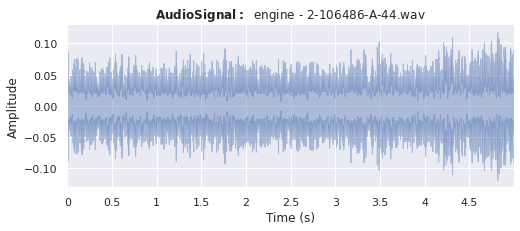

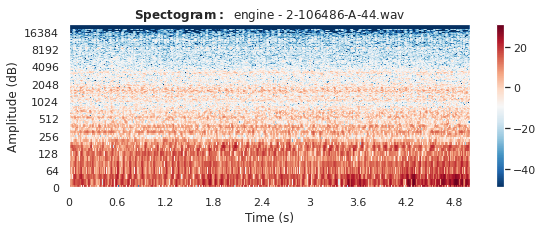

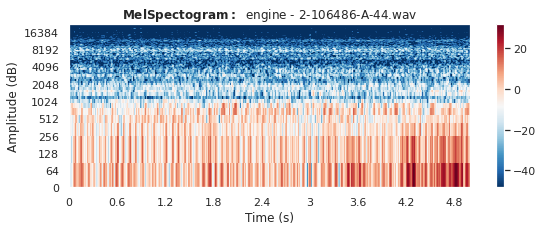

In [9]:
rnd_clip.DisplayWave()
rnd_clip.DisplaySpectrogram()
rnd_clip.DisplayMelSpectrogram();

The formal definition of the features we are going to extract has already been provided above, so we will now go for a visive overview of them: remember that all the quantities listed are frame features, in the sense that we will compute one (or more) value *per frame* for each of them, and since each clip is composed by 431 frames, we will have to deal with entire distributions rather than single values.

In [10]:
rnd_clip.Compute_Features('all')

The first 3 features are directly computed over the spectrum of the wave, and their purpose is to provide an high-level "summarized" description of it. We are talking about the centroids, the rolloffs and the bandwidth parameters.

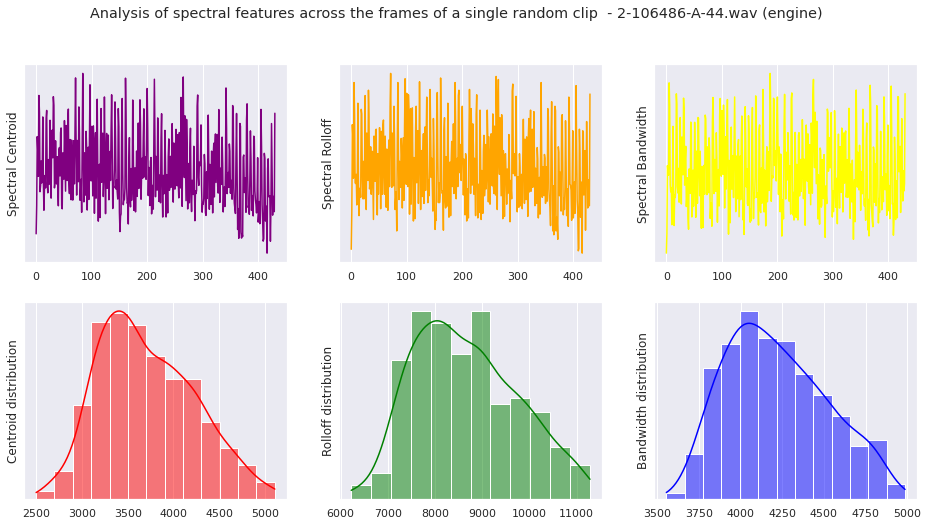

In [11]:
fig, ax = plt.subplots(2,3,figsize=(16,8))
fig.suptitle('Analysis of spectral features across the frames of a single random clip  - ' + 
             rnd_clip.clipname + ' (' + rnd_clip.category + ')' )

sns.lineplot(x=np.arange(431), y=rnd_clip.features['spectral centroid'], color='purple', ax=ax[0,0])
ax[0,0].set_ylabel('Spectral Centroid')
ax[0,0].set_yticks([])

sns.lineplot(x=np.arange(431), y=rnd_clip.features['spectral rolloff'], color='orange', ax=ax[0,1])
ax[0,1].set_ylabel('Spectral Rolloff')
ax[0,1].set_yticks([])

sns.lineplot(x=np.arange(431), y=rnd_clip.features['spectral bandwidth'], color='yellow', ax=ax[0,2])
ax[0,2].set_ylabel('Spectral Bandwidth')
ax[0,2].set_yticks([])

sns.histplot(rnd_clip.features['spectral centroid'], kde=True, color='red', ax=ax[1,0])
ax[1,0].set_ylabel('Centroid distribution')
ax[1,0].set_yticks([])

sns.histplot(rnd_clip.features['spectral rolloff'], kde=True, color='green', ax=ax[1,1])
ax[1,1].set_ylabel('Rolloff distribution')
ax[1,1].set_yticks([])

sns.histplot(rnd_clip.features['spectral bandwidth'], kde=True, color='blue', ax=ax[1,2])
ax[1,2].set_ylabel('Bandwidth distribution')
ax[1,2].set_yticks([]);

The distribution obtained are in general not very regular but anyway "simple", in the sense that they are usually peaked on a certain value, or uniform in a certain interval, depending on the structure of the particular wave analyzed.

But let's give a look to the more interesting part of the analysis, i.e. the features that apparently will be more helpful for a good discrimination (alse the most used for this kind of purposes): the zero-crossing rate and the Mel-Frequency-Cepstral coefficients. First let's recall what do they represent: 
* the _zero crossing rate_ is the rate at which the signal changes from positive to negative and viceversa, and it's a key characteristic of percussive sounds;
* the _MFCC_ are a small set of features which concisely describe the overall shape of a spectral envelope, modeling, at the same time, the characteristics of the human voice.

*As explained also in the documentation of the code, only 12 MFCC will be kept, as they are the most interesting, with the very first one being discarded, mainly because its absolute value comes from the normalization of the discrete cosine transform that is performed over the power spectrum.*

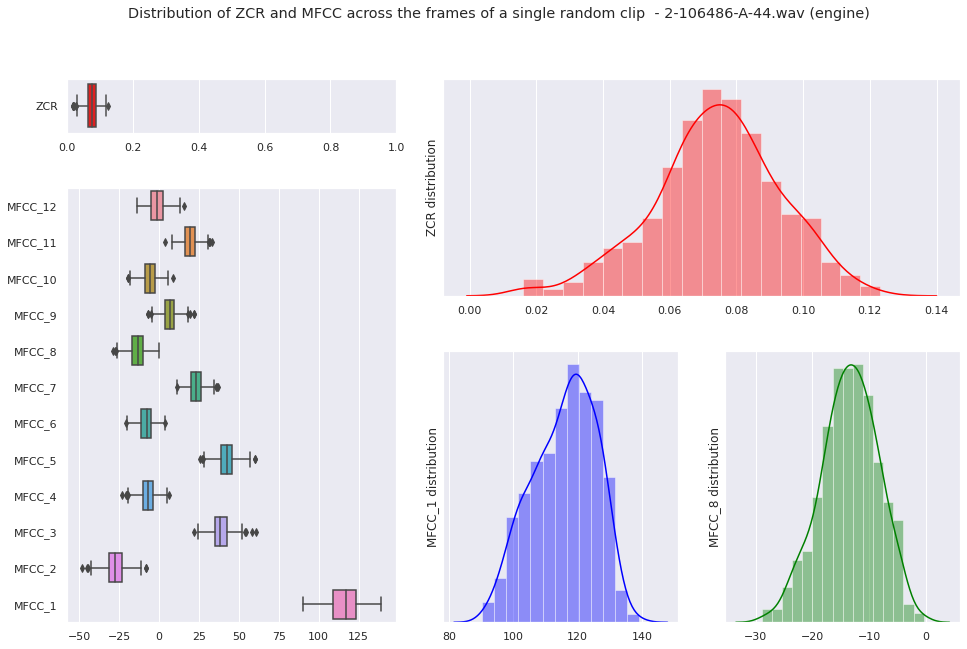

In [12]:
fig = plt.figure(figsize=(16,10))
ax = [0]*5
fig.suptitle('Distribution of ZCR and MFCC across the frames of a single random clip  - ' + 
             rnd_clip.clipname + ' (' + rnd_clip.category + ')' )

grid = GridSpec(10, 10, wspace=1, hspace=0.01)
ax[0] = fig.add_subplot(grid[0  , :4])
ax[1] = fig.add_subplot(grid[2: , :4])
ax[2] = fig.add_subplot(grid[ :4,4: ])
ax[3] = fig.add_subplot(grid[5: ,4:7])
ax[4] = fig.add_subplot(grid[5: ,7:])

MFCC = pd.DataFrame(rnd_clip.features['mfcc'].T, columns=list('MFCC_{}'.format(i+1) for i in range(12)))
ZCR = pd.DataFrame(rnd_clip.features['zero-crossing rate'][0], columns=['ZCR'])

sns.boxplot(data=ZCR, orient='h', color='red', ax=ax[0])
ax[0].set_xlim(0,1)

sns.boxplot(data=MFCC, orient='h', order=list(reversed(MFCC.columns)), ax=ax[1])

sns.distplot(rnd_clip.features['zero-crossing rate'][0], color='red', ax=ax[2])
ax[2].set_ylabel('ZCR distribution')
ax[2].set_yticks([])

sns.distplot(rnd_clip.features['mfcc'][0], color='blue', ax=ax[3])
ax[3].set_ylabel('MFCC_1 distribution')
ax[3].set_yticks([])

rnd_mfcc = np.random.randint(2,12)
sns.distplot(rnd_clip.features['mfcc'][rnd_mfcc], color='green', ax=ax[4])
ax[4].set_ylabel('MFCC_' + str(rnd_mfcc+1) + ' distribution')
ax[4].set_yticks([]);

Looking at the MFCC boxplot, we can clearly see that the first (and in some cases also the second) coefficients are much more dispersed than the others, and this is also confirmed looking at the MFCC_0 distribution shown in the right plot. This means that most of the information provided by those coefficients is stored in the first ones, as expected, since basically they come from a discrete cosine transform. Conventionally only 12 of them are kept for sound classification tasks,, and so we do for our analysis.

However, it is important to specify that these features are mainly used in speech recognition tasks, and so one can expect them to underperform when dealing with environmental sound classification, at least compared to the objective they are designed to. And this is the main reason for which our final "vector of features" is composed also by many other values, in order to provide an high-level description that is as complete as possible, at the expense of the computational resources required.

*Second important remark: apparently mfcc values are not very robust when dealing with noisy waves, and this could be a problem when studying environmental sounds, or when performing augmentation in order to have more data to analyze. Actually there is not an "official" procedure to deal with it, just the heuristic suggestions of being careful with the results and normalizing the features before using them.*

The last couple of features that is worth to give a look at (the remaining ones are just the first and second derivatives of the others) are the chromagram and the energy spectrum. The chromagram is a 12 element feature vector, just like the mfcc, indicating how much energy of each pitch class is present in the signal. Environmental audio classification is not the main task for which chromagrams are designed to, since they are more useful when distinguishing among music styles, but in some way they may help also for our task.

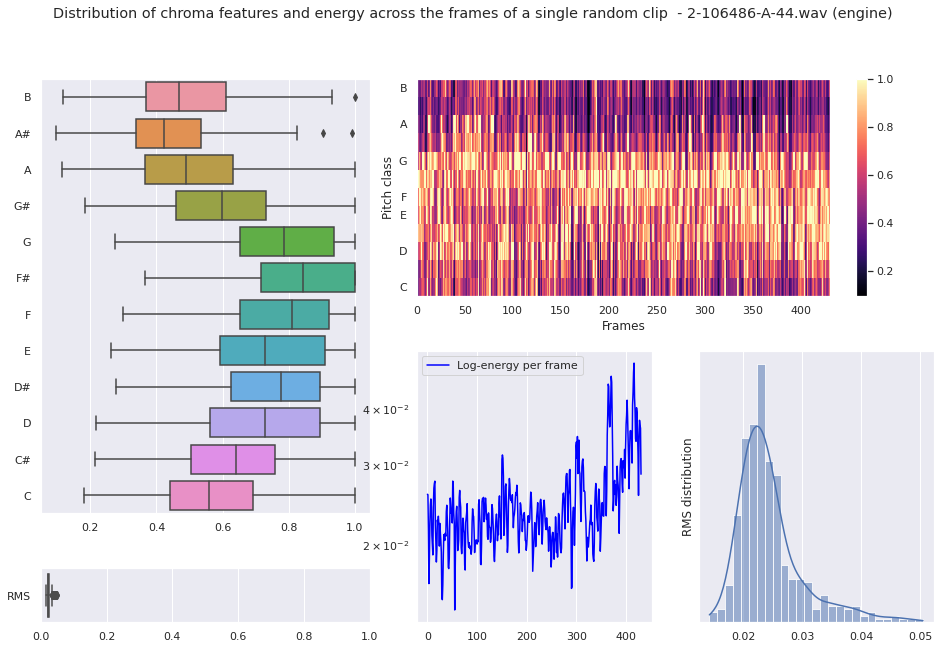

In [13]:
fig = plt.figure(figsize=(16,10))
ax = [0]*5
fig.suptitle('Distribution of chroma features and energy across the frames of a single random clip  - ' + 
             rnd_clip.clipname + ' (' + rnd_clip.category + ')' )

grid = GridSpec(10, 10, wspace=1, hspace=0.01)
ax[0] = fig.add_subplot(grid[0:8, :4])
ax[1] = fig.add_subplot(grid[9  , :4])
ax[2] = fig.add_subplot(grid[ :4,4: ])
ax[3] = fig.add_subplot(grid[5: ,4:7])
ax[4] = fig.add_subplot(grid[5: ,7:])

RMS = pd.DataFrame(rnd_clip.features['energy'][0], columns=['RMS'])
CHROMA = pd.DataFrame(rnd_clip.features['chromagram'].T, 
                      columns=['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#' , 'B'])

sns.boxplot(data=CHROMA, orient='h', order=list(reversed(CHROMA.columns)), ax=ax[0])

sns.boxplot(data=RMS, orient='h', color='red', ax=ax[1])
ax[1].set_xlim(0,1);

img = librosa.display.specshow(rnd_clip.features['chromagram'], y_axis='chroma', x_axis='frames', ax=ax[2])
fig.colorbar(img, ax=ax[2])

sns.lineplot(x=np.arange(431), y=rnd_clip.features['energy'][0], ax=ax[3], color='blue', 
             label='Log-energy per frame')
ax[3].set_yscale('log')

sns.histplot(rnd_clip.features['energy'][0], kde=True, stat='density', ax=ax[4])
ax[4].set_ylabel('RMS distribution')
ax[4].set_yticks([]);

Now it's time to discuss about probably the most important and, at the same time, questionable, point in classification via feature extraction: we have decided to compute a total of 55 features but, as said before, they are calculated frame by frame, and with overall 431 frames, a complete vector of features would have size _NFEAT*NFRAMES_ = 55*431 = 23705! <br>
This is obviously too much, and so we need to find a way to represent all the features across the frames with a limited number of parameters.

The first and also the most immediate way that one can think about is representing each feature with its mean across all the frames, leading to vectors of overall size _NFEAT_ = 55. But is this enough? Is the vector created enough representative of the entire clip? <br>
Let's give a look first to the following examples.

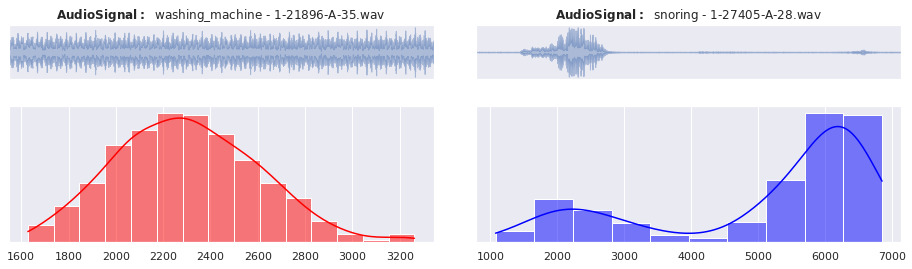

In [14]:
exampleA = Clip(audio_dir + '1-21896-A-35.wav', label_map)
exampleB = Clip(audio_dir + '1-27405-A-28.wav', label_map)

compared_feat = 'spectral centroid'
exampleA.Compute_Features([compared_feat])
exampleB.Compute_Features([compared_feat])

fig = plt.figure(figsize=(16,4))
ax = [0]*4
grid = GridSpec(3, 2, wspace=0.1, hspace=0.5)
ax[0] = fig.add_subplot(grid[0  ,   0])
ax[1] = fig.add_subplot(grid[1: ,   0])
ax[2] = fig.add_subplot(grid[0  ,   1])
ax[3] = fig.add_subplot(grid[1: ,   1])

exampleA.DisplayWave(ax[0])
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel('')
ax[0].set_ylabel('')

sns.histplot(exampleA.features[compared_feat], kde=True, color='red', ax=ax[1])
ax[1].set_yticks([])
ax[1].set_ylabel('')

exampleB.DisplayWave(ax[2])
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_xlabel('')
ax[2].set_ylabel('')

sns.histplot(exampleB.features[compared_feat], kde=True, color='blue', ax=ax[3])
ax[3].set_yticks([])
ax[3].set_ylabel('');

In the previous plot I took two clips that are meaningful to represent the two different situations that can occur when extracting features from our data. Moreover, I deciced to plot the _spectral centroid_ distribution simply because the differences among the cases are more evident, but the same results could have been obtained also with other features. <br>

The first thing that comes to our eyes is the difference among the two distributions: the left one is more symmetric, more gaussian, while the second one is more sparse, less regular. So, if the mean could represent a good estimator for the first distribution, the same cannot be said for the second distribution. <br>
One possible solution could be relying on other statistical estimators:
* the **standard deviation**, to measure the dispersion of our data
* the **median**

From heuristic tests, using simple classifiers, it turned out that representing features using more statistical estimators rather than just the mean, strongly improves the final accuracy, in some cases even doubling it (_SVM, 30% -> 60%_ ). This is more due to the presence of a dispersion measure like the standard deviation rather than both estimators. So, since the median will not impact significately the accuracy of the methods we are going to implement, in order to avoid overfitting and reduce the computational time, we will summarize our feature distribution just with its mean and standard deviation.

The last problem that I would like to talk about is the presence of silence in the clips. <br>
Let's look at this particular clip.

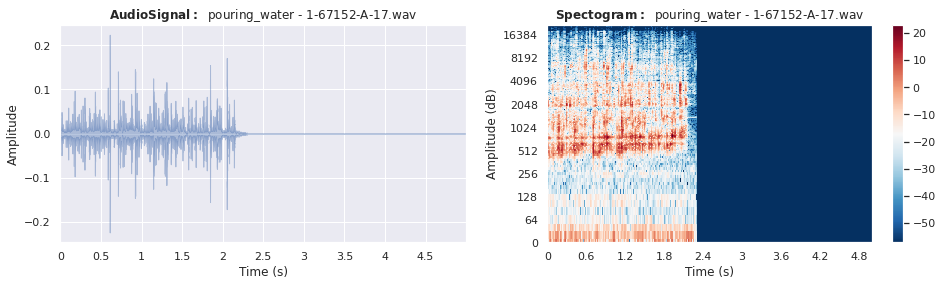

In [71]:
silent_clip = Clip(audio_dir + '1-67152-A-17.wav', label_map)

fig, ax = plt.subplots(1, 2, figsize=(16,4))
silent_clip.DisplayWave(ax=ax[0])
silent_clip.DisplaySpectrogram(ax=ax[1]);

As can be seen, from a certain point on, there is no more sound in the clip, and this is not a peculiarity of this specific clip, but is a recurrent pattern in many sounds. The causes can be many: maybe the sound is very short and the file has been padded with zeros to reach the conventional 5 seconds, or maybe we are dealing with a clip that alternates parts of noise to parts of silence. But this can strongly impact the distributions of the features that we are going to compute!

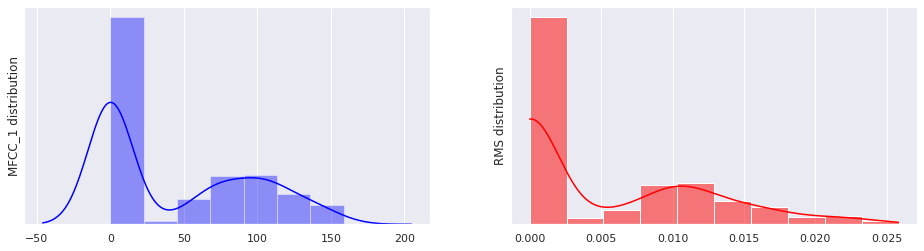

In [72]:
silent_clip.Compute_Features('all')

fig, ax = plt.subplots(1, 2, figsize=(16,4))
sns.distplot(silent_clip.features['mfcc'][0], color='blue', ax=ax[0])
ax[0].set_ylabel('MFCC_1 distribution')
ax[0].set_yticks([])

sns.histplot(silent_clip.features['energy'][0], kde=True, stat='density', color='red', ax=ax[1])
ax[1].set_ylabel('RMS distribution')
ax[1].set_yticks([]);

As can be seen, the presence of silent parts makes the zero-columns of our distributions to drastically increase, completely "ruining" its regularity. One possibility to deal with this problem could be "forgetting" about zeros when computing the statistical variables of our features: in this way the mean would result just re-scaled, while the standard deviation and the median would be affected much more. Again, from our heuristic tests, negletting zeros in our calculation can further improve the accuracy of our models in same cases, on average of a percentage around +2/+5%. <br> 
The fact is that, in this way, you can improve the capability of distinguishing among short sounds, but at the same time you are losing information about repetitive sounds, like some animal noises.

A possible tradeoff between the two situation has been found defining a further preprocessing step, not on the clips, but directly on the features, according to which if we are able to find fix sized windows of silence, using the energy of the spectrum as a discriminator, we "forget" about those entire (non-overlapping) windows when computing the statistical estimators of the distributions. <br>
In practice what we do is the following:
1. Take the energy vector of the clip, and search for continuous non-overlapping sequences of zeros, whose size is given in seconds (rememeber that 431 frames correspond to 5.0 seconds).
2. Get the indices of those windows in order to construct a "window pattern".
3. According to that pattern, when computing mean and std of the features of the clip, do not take into account the values correspoding to such frames.

In [143]:
def get_zero_windows(vector, window_size):
    """This function takes in input a numerical 1D array and search in it for fixed sized sequences of zeros. 
    Then, it will return a vector a vector of booleans of the same size of the input one, to be used to
    select such windows."""
    
    temp = vector.copy()
    # For conveniency, convert all the non-zero elements of the array into ones
    temp[temp>(1e-6)] = 1
    temp_str = ''.join(str(int(x)) for x in temp)
    del temp
    it = re.finditer(pattern='0{'+str(window_size)+'}', string=temp_str)
    
    window_pattern = [False]*len(vector)
    
    for index in [x.start() for x in it]:
        window_pattern[index:index+window_size] = [True]*window_size
        
    return window_pattern

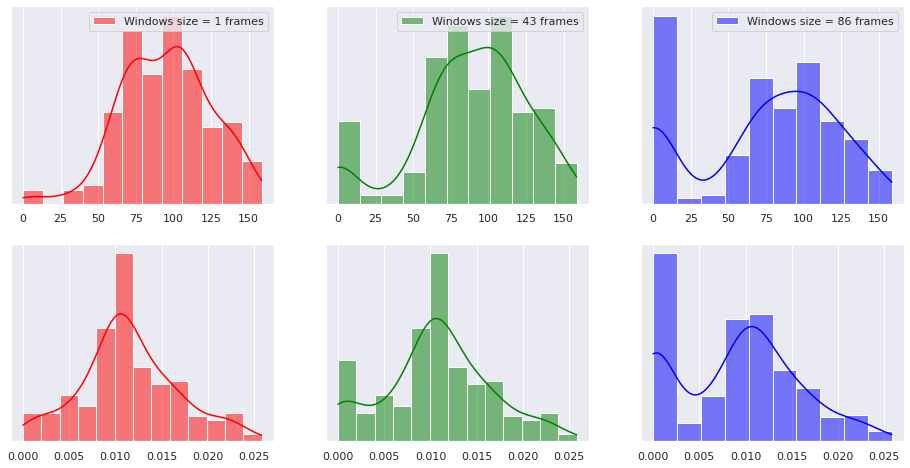

In [219]:
fig, ax = plt.subplots(2, 3, figsize=(16,8))
ax = ax.flatten()
colors = ['red', 'green', 'blue']

for i, time_w in enumerate([1/86., 0.5, 1]):
    
    silent_window = get_zero_windows(vector=silent_clip.features['energy'].T, window_size=int(431//5*time_w))
    
    s_mfcc1 = silent_clip.features['mfcc'][0].copy()
    s_energy = silent_clip.features['energy'].flatten().copy()
    
    s_mfcc1[silent_window] = np.nan
    s_energy[silent_window] = np.nan
    
    sns.histplot(s_mfcc1, kde=True, stat='density', color=colors[i], ax=ax[i], 
                 label='Windows size = ' + str(int(431//5*time_w)) + ' frames')
    ax[i].set_yticks([])
    ax[i].set_ylabel('')
    ax[i].set_title('')
    ax[i].legend()
    
    sns.histplot(s_energy, kde=True, stat='density', color=colors[i], ax=ax[3+i])
    ax[3+i].set_yticks([])
    ax[3+i].set_ylabel('')
    ax[3+i].set_title('')

As can be seen from the example, we managed to reduce the irregularity of the parameter distribution, at least in most of the cases. In order to have a good, "balanced" tradeoff, we decided to pick windows of size 0.5 seconds (43 frames), such that many short sound will be "restricted" only to the effective region of interest, while periodic waves will be affected only if the break between two consecutive rises is bigger than half a second (that anyway correspond to the 10% of the total length, and so it is a reasonable treshold).

## Dataset Construction

Let's now load the entire dataset constructing a labelled dataframe of _Clip_ objects.

In [161]:
def Collect_Clips(data_dir, label_map, macro_map):
    df = pd.DataFrame(None, columns=["macro-category", "label", "clip"])
    for i, file in enumerate(tqdm(sorted(os.listdir(data_dir)))):
        num_label = int(file.split('-')[3].split('.')[0])
        cat_label = label_map[num_label]
        macro_label = macro_map(num_label)
        track = Clip(data_dir + file, label_map)
        df.loc[i] = macro_label, cat_label, track
    return df
        
data = Collect_Clips(audio_dir, label_map, macro_categories_map)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [162]:
data

,macro-category,label,clip
0,Animals,dog,<__main__.Clip object at 0x7f9c757fc210>
1,Natural soundscapes and water sounds,chirping_birds,<__main__.Clip object at 0x7f9c77b62b10>
2,Interior/domestic sounds,vacuum_cleaner,<__main__.Clip object at 0x7f9c76947c50>
3,Interior/domestic sounds,vacuum_cleaner,<__main__.Clip object at 0x7f9c44274c10>
4,Natural soundscapes and water sounds,thunderstorm,<__main__.Clip object at 0x7f9c76947350>
...,...,...,...
1995,Animals,hen,<__main__.Clip object at 0x7f9c56972c10>
1996,Interior/domestic sounds,vacuum_cleaner,<__main__.Clip object at 0x7f9c5693a050>
1997,"Human, non-speech sounds",footsteps,<__main__.Clip object at 0x7f9c5693a510>
1998,Animals,sheep,<__main__.Clip object at 0x7f9c5693a4d0>


Then, collected all the necessary *Clip* objects, we need to extract from them all the necessary information for the final classification task, keeping the amount of data reasonable.

In [35]:
def Construct_Vector_Features(clip, stat=['mean'], silence_elimination=0):
    """Given a Clip object, this function return an array with all the summarized features per frame. 
    By default, the distributions are represented with their mean, but other statistical measures, 
    can be selected. If you want to drop windows of zeros in those vectors, you insert the time in
    seconds in the parameter silence_elimination."""
    
    if silence_elimination != 0:
        # Select a window based on the energy values
        silent_windows = get_zero_windows(vector=clip.features['energy'].T, 
                                          window_size=int(431//5*silence_elimination))
    
    vector = []
    feat_dict = clip.features.copy()

    # Single features
    for feat in ['spectral centroid', 'spectral rolloff', 'spectral bandwidth', 'zero-crossing rate', 
                 'energy', 'delta-energy', 'delta-delta-energy']:

        if silence_elimination != 0: 
            if feat_dict[feat].shape[0]!=431: feat_dict[feat].flatten()[silent_windows] = np.nan
                    
        if 'mean' in stat: 
            vector += [np.nanmean(feat_dict[feat])]
        if 'std'  in stat: 
            vector += [np.nanstd(feat_dict[feat])]
        if 'median' in stat: 
            vector += [np.nanmedian(feat_dict[feat])]
        
    # N-dimensional features
    for feat in ['mfcc', 'chromagram', 'delta', 'delta-delta']:
        
        if silence_elimination != 0: feat_dict[feat][:,silent_windows] = np.nan
        
        if 'mean' in stat: 
            vector += list(np.nanmean(feat_dict[feat], axis=1))
        if 'std'  in stat: 
            vector += list(np.nanstd(feat_dict[feat], axis=1 ))
        if 'median' in stat: 
            vector += list(np.nanmedian(feat_dict[feat], axis=1))
        
    return np.array(vector)


Construct_Vector_Features(rnd_clip, silence_elimination=0).shape

(55,)

Now that we have defined a way to build the *X_vectors* to give in input to our classifier, the next step is to construct a dataframe including such vectors but for all the clips available. Each line of such dataframe will correspond to a single audio file, with the last column initialized with a numeric target indicating the label/category of the clip.

In [36]:
def extract_features(dataset, stat=['mean'], silence_window=0, csv_filename=None):
    """Given a dataset containing all the instances of the class Clip, this function construct a pandas 
    dataframe in which each row is composed by the vector of features of one clip, and its corresponding
    label. Then, it can save the result in a csv file."""
    
    n_features = 55
    
    features_df = pd.DataFrame(columns=[i for i in range(n_features*len(stat))])
    
    for index, row in tqdm(dataset.iterrows(), total=len(dataset)):
        
        # Compute all the features useful for the classification
        sample = row['clip']
        sample.Compute_Features('all')
        
        features_df.loc[index] = Construct_Vector_Features(sample, stat, silence_window)
        
    features_df['label'] = dataset['label']
    
    if csv_filename is not None: features_df.to_csv(csv_filename)
        
    return features_df

In this way, if the *csv* file has already been created, you don't need to reload from the beginning all the data, but just that file.

Notice that the parameters of the loading process are the optimal one according to the heuristic tests of which we have spoken in the previous section:
* Usage of _mean_ and _standard deviation_ to summarize parameters distributions.
* Elimination of silence windows that are 0.5 seconds long.

In [163]:
extract_features(data, stat=['mean','std'], silence_window=0.5, csv_filename='features.csv')

  0%|          | 0/2000 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9,...,101,102,103,104,105,106,107,108,109,label
0,273.927703,1168.622070,436.259698,2074.699983,255.475244,976.942865,0.007329,0.027503,0.007518,0.040822,...,0.899202,0.721955,1.107690,0.435245,0.451013,0.538303,0.727118,0.500143,0.450082,dog
1,4043.327516,537.181203,6625.132097,631.124050,2645.356543,178.365557,0.157994,0.022784,0.048209,0.038197,...,0.931000,1.279261,1.160237,0.748184,0.666160,0.725012,1.007626,0.584620,0.725929,chirping_birds
2,4410.473294,390.254843,8363.825837,569.020290,4051.233312,161.197379,0.199469,0.029614,0.271365,0.046708,...,0.581274,0.522859,0.588512,0.512404,0.635812,0.576114,0.571322,0.597317,0.546289,vacuum_cleaner
3,4369.644056,224.081560,8418.533162,316.244594,3946.844138,111.435264,0.202079,0.021309,0.275260,0.066043,...,0.621989,0.557757,0.521746,0.502744,0.488045,0.450892,0.565211,0.577689,0.526760,vacuum_cleaner
4,2075.696947,584.761524,4559.843116,1906.344111,3455.549264,500.923009,0.027574,0.010662,0.008845,0.006442,...,0.607379,0.525161,0.514323,0.565485,0.554065,0.489864,0.528734,0.506565,0.558096,thunderstorm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1918.757528,303.783879,3106.227002,644.665288,2170.010452,434.008532,0.053308,0.018209,0.085123,0.087223,...,1.589473,0.908361,1.263996,0.991909,0.835533,0.968926,0.802479,0.763298,0.794067,hen
1996,5685.663242,143.534391,11292.940994,253.468461,4396.309142,68.666402,0.227157,0.017203,0.119567,0.003821,...,0.536032,0.487366,0.492283,0.451245,0.463138,0.476303,0.451795,0.511070,0.498505,vacuum_cleaner
1997,1931.486868,1329.795683,4316.632831,3188.653985,2824.456677,1655.568125,0.025522,0.025662,0.065660,0.094834,...,1.224146,0.850813,0.775175,0.799110,0.885374,0.834324,0.756124,0.759324,0.636704,footsteps
1998,3503.472061,940.171052,7393.582670,3105.111474,3994.320503,921.695082,0.075558,0.021528,0.061051,0.040678,...,0.767034,0.722414,0.723565,0.600105,0.629163,0.528401,0.590463,0.632595,0.592112,sheep


So, we will train our models exploiting vector of features of size 110.

In [164]:
# For comparison purposes, let's create also a couple of dataframes with different configuration
extract_features(data, stat=['mean','std'], csv_filename='features_nosilenceremoval.csv')
extract_features(data, stat=['mean'], silence_window=0.5, csv_filename='reduced_features.csv')

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,label
0,273.927703,436.259698,255.475244,0.007329,0.007518,-1.728673e-11,0.000000e+00,40.658272,-32.987862,-21.257250,...,0.018825,-0.014721,-0.010674,0.000276,-0.000458,-0.001974,0.001086,0.001107,-0.003369,dog
1,4043.327516,6625.132097,2645.356543,0.157994,0.048209,-4.059709e-04,-1.895245e-04,85.773117,-107.046501,30.983370,...,0.045876,0.021108,0.045778,0.005082,0.033905,0.028442,0.017804,0.000603,-0.002458,chirping_birds
2,4410.473294,8363.825837,4051.233312,0.199469,0.271365,1.874928e-04,1.906741e-05,102.513878,-40.429398,39.036442,...,-0.018722,-0.000396,-0.025225,-0.003767,-0.011079,-0.004380,-0.015358,-0.015952,0.005087,vacuum_cleaner
3,4369.644056,8418.533162,3946.844138,0.202079,0.275260,-4.789268e-04,3.586680e-05,104.311104,-43.096550,42.293339,...,-0.011646,-0.012005,0.020964,0.006608,0.006231,0.003843,0.005598,0.004998,0.018738,vacuum_cleaner
4,2075.696947,4559.843116,3455.549264,0.027574,0.008845,-1.383832e-06,6.924677e-07,144.254349,22.956751,52.225975,...,-0.006090,-0.006453,-0.002683,-0.000314,-0.004698,0.002825,0.006675,0.005429,-0.011123,thunderstorm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1918.757528,3106.227002,2170.010452,0.053308,0.085123,-5.469435e-05,1.474639e-05,166.435074,-42.420334,-7.613806,...,-0.016490,-0.012526,-0.024059,-0.011351,0.001157,0.005215,0.006507,0.008177,0.002809,hen
1996,5685.663242,11292.940994,4396.309142,0.227157,0.119567,1.241699e-05,-1.923878e-07,93.596451,-61.999809,60.737045,...,0.027872,-0.003745,0.017746,0.001876,0.010321,-0.000338,0.002137,0.004457,-0.001272,vacuum_cleaner
1997,1931.486868,4316.632831,2824.456677,0.025522,0.065660,-6.066287e-05,1.229334e-04,126.603394,4.795046,29.478708,...,0.005142,0.006725,-0.008757,0.013787,0.006001,0.015286,-0.012937,-0.003849,-0.015722,footsteps
1998,3503.472061,7393.582670,3994.320503,0.075558,0.061051,-7.792808e-04,-2.959469e-05,130.957718,-38.246578,7.836995,...,0.023197,-0.015802,0.026643,-0.003816,0.026449,-0.011770,0.012469,0.005262,0.010000,sheep


### Plot Generation

As was anticipated in the introduction, in this analysis we will implement also several Convolutional Neural Networks, with the purpose of provinding a set of tools that guaranteed optimal performances in our classification task even without computing all the features that we have talked about before. But CNN works with images, and for this reason we define a of function able to generate 3 kind of images from our clip dataset: a folder with the time waves, another one with the spectrogram and the last one with all the MelSpectrogram. Later on, the performances of the various networks over these 3 new datasets will be computed and compared. 

In [ ]:
folders = ['time_signals/', 'spectrograms/', 'melspectrograms/']
def save_plots(data):
    for clip in tqdm(data['clip']):
        fig, ax = plt.subplots(1,1,figsize=(6,3))
        clip.DisplayWave(ax)
        ax.set_title('')
        ax.set_axis_off()
        fig.savefig(os.getcwd() + '/audio_plots/' + folders[0] + clip.clipname.split('.')[0], 
                    bbox_inches='tight', pad_inches=0)
        fig.clear()
        
        ax = fig.add_axes([1,1,1,1])
        clip.DisplaySpectrogram(ax, cbar=False)
        ax.set_title('')
        ax.set_axis_off()
        fig.savefig(os.getcwd() + '/audio_plots/' + folders[1] + clip.clipname.split('.')[0], 
                    bbox_inches='tight', pad_inches=0)
        fig.clear()
        
        ax = fig.add_axes([1,1,1,1])
        clip.DisplaySpectrogram(ax, cbar=False)
        ax.set_title('')
        ax.set_axis_off()
        fig.savefig(os.getcwd() + '/audio_plots/' + folders[2] + clip.clipname.split('.')[0], 
                    bbox_inches='tight', pad_inches=0)
        fig.clear()
            
#save_plots(data)

### Quick visual overview of the problem

As anticipated in the introduction, in the dataset made of 2000 clips we can identify 10 macro-categories, referred to several kinds of environmental sounds, and the data have been collected in order to have exactly 40 files for each category. <br>
In the following cells we will try to give a first quick visual representation of samples belonging to different macro-categories.

In [165]:
def clip_overview(clip, ax):
    """Reproduce, in a unique figure, the raw sound, the spectrogram and the Melspectrogram."""
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax_waveform       = ax.inset_axes([0.0, 0.8, 1.0, 0.2])
    ax_spectrogram    = ax.inset_axes([0.0, 0.4, 1.0, 0.4])
    ax_melspectrogram = ax.inset_axes([0.0, 0.0, 1.0, 0.4])
    
    with clip.audio as audio:
        librosa.display.waveplot(audio.raw, sr=audio.rate, ax=ax_waveform, alpha=0.4)
        X_s = librosa.stft(audio.raw)
        Xdb_s = librosa.amplitude_to_db(abs(X_s))
        librosa.display.specshow(Xdb_s, sr=audio.rate, ax=ax_spectrogram, x_axis='time', y_axis='log', cmap='RdBu_r')
        X_ms = librosa.feature.melspectrogram(audio.raw, sr=audio.rate)
        Xdb_ms = librosa.amplitude_to_db(abs(X_ms))
        librosa.display.specshow(Xdb_ms, sr=audio.rate, ax=ax_melspectrogram, x_axis='time', y_axis='log', cmap='RdBu_r')
        ax_waveform.set_title(clip.category)    
        
    ax_waveform.get_xaxis().set_visible(False)
    ax_waveform.get_yaxis().set_visible(False)
    ax_spectrogram.get_xaxis().set_visible(False)
    ax_spectrogram.get_yaxis().set_visible(False)
    ax_melspectrogram.get_xaxis().set_visible(False)
    ax_melspectrogram.get_yaxis().set_visible(False)
    
    return

Macro category: Animals


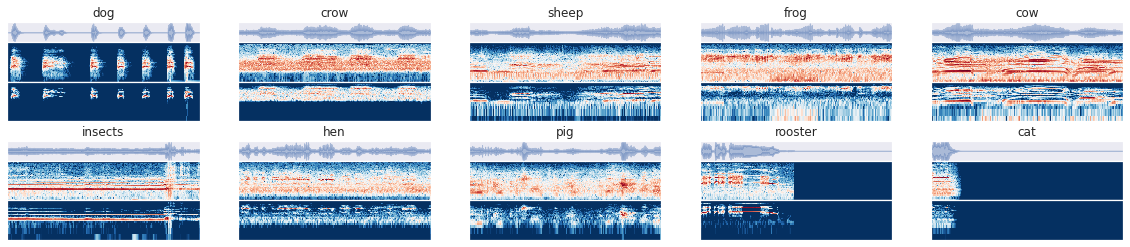

Macro category: Natural soundscapes and water sounds


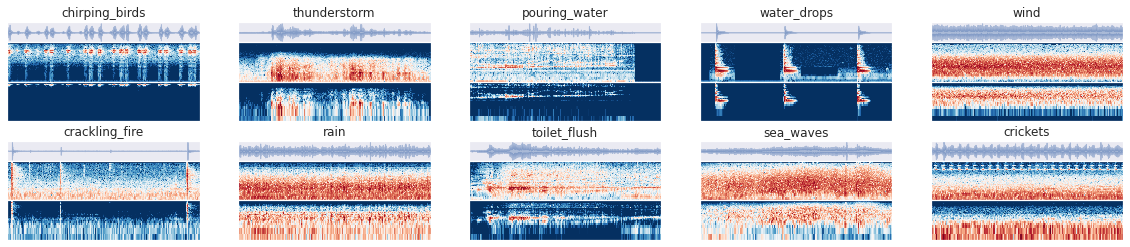

Macro category: Interior/domestic sounds


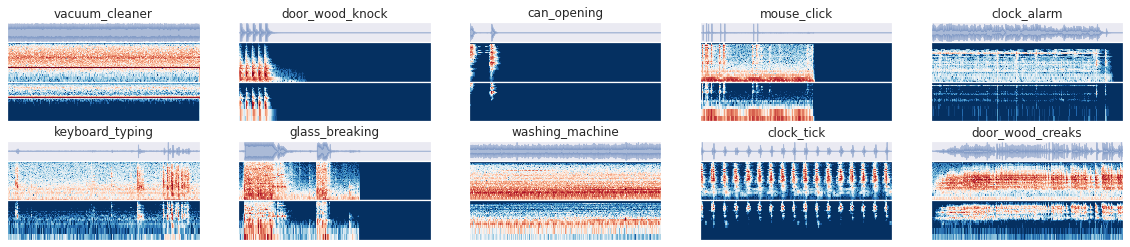

Macro category: Human, non-speech sounds


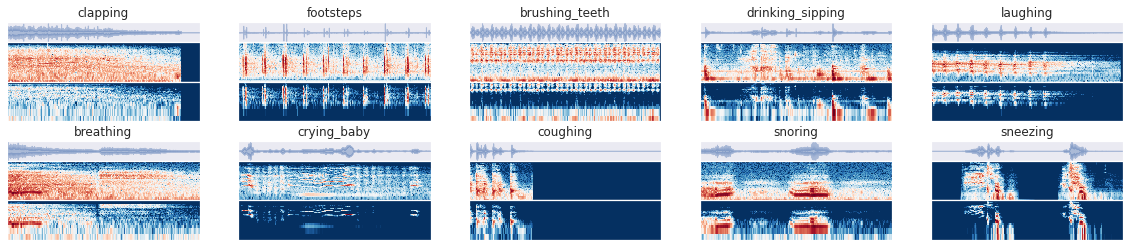

Macro category: Exterior/urban noises


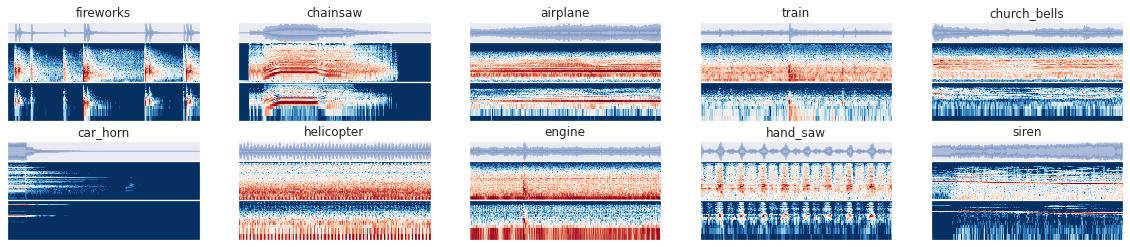

In [167]:
for macro_cat in data['macro-category'].unique():
    micro_cat = data.loc[data['macro-category']==macro_cat, 'label'].unique()
    samples_per_category = len(micro_cat)
    print('Macro category:', macro_cat)
    fig, axs = plt.subplots(2, (samples_per_category+1)//2, figsize=(samples_per_category*2, 4), sharex=True, sharey=True)
    axs = axs.flatten()
    
    for i, lab in enumerate(micro_cat):
        cat_clip = np.random.choice(data.loc[(data['macro-category']==macro_cat) & (data['label']==lab), 'clip'])
        clip_overview(cat_clip, axs[i])
    
    plt.show()

### Correlation Matrix

What if some features appear to be more correlated than some others?

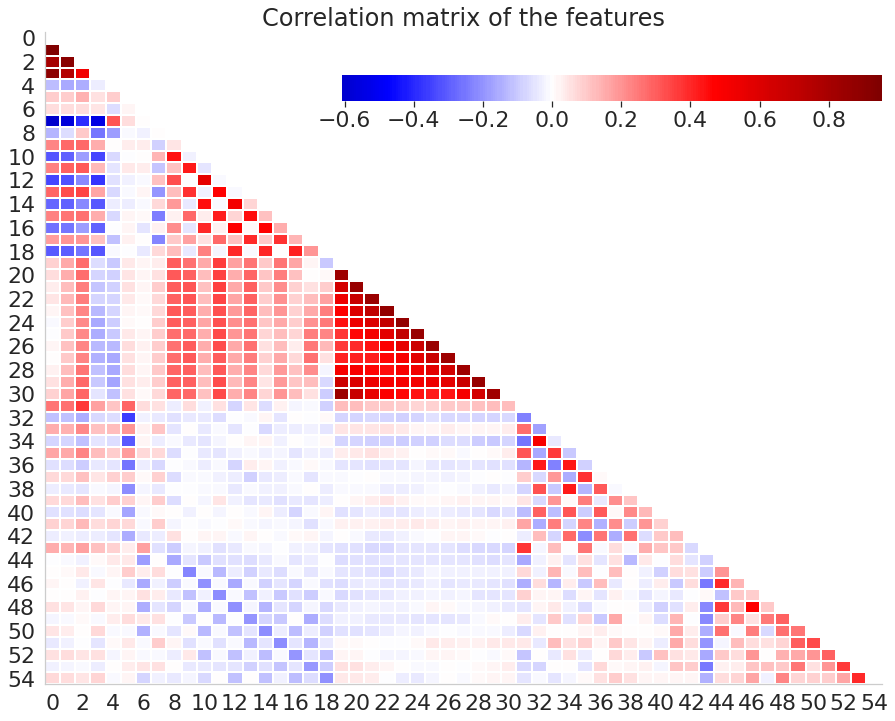

In [216]:
# Take again the random sample selected before and just the mean of the feature distributions, for simplicity
red_feat = pd.read_csv("reduced_features.csv", index_col=0)
feat_df = red_feat.drop(['label'], axis=1)

corr_matrix = feat_df.corr()
corr_fig, corr_ax = plt.subplots(figsize=(15,12))

# Since the correlation matrix is symmetric respect to the principal diagonal, we can just plot half of it
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True

cbaxes = corr_fig.add_axes([0.4, 0.8, 0.5, 0.03]) 

sns.heatmap(corr_matrix, center=0, mask=mask, ax=corr_ax, linewidths=1, cmap='seismic', cbar_ax=cbaxes,
            cbar_kws={'fraction':0.05, 'orientation':'horizontal'})
corr_ax.set_title("Correlation matrix of the features")
sns.set(font_scale=2)
sns.set_style("dark")
sns.despine()


# Classification

In [ ]:
from tqdm.keras import TqdmCallback
import keras
from keras import layers
from keras import layers
import keras
from keras.models import Sequential
import warnings
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, KFold
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
warnings.filterwarnings('ignore')

In [ ]:
class ClipsClassifier():
    """The purpose of this class is to collect all the necessary steps and functions to construct a classification
    model for our clips. 
    In particular, all the necessary steps to prepare the input dataset for the training process will 
    be implemented:
    * standardization
    * PCA
    * One Hot Encoding
    * train test split
    Then a k-fold cross validation can be made in order to test several combination of hyperparameters
    without constructing directly a validation set.
    In the end, the performances will be shown in term of accuracy/loss also over different macro-categories
    to finally quantify the quality of the model constructed.
    """
    
    def __init__(self, dataset):
        """Initialize some global parameters.
        Dataset is a pandas dataframe with several "features" columns and one "label" column, 
        that contains the data that we want to fit."""
        
        self.data = dataset        
        self.Setup_Classifier()
        
        self.setup_completed = False
        
        self.best_model = None
        self.hyperparameters_tuning_dict = {}
        self.nested_scores = []
        
        self.confusion_matrix = None
        
        
    def Setup_Classifier(self, pca_percentage=0.99, n_folds=5, n_jobs=-1,
                         scaler_method='standard', encoder_method='onehot'):
        """Change the value of some parameters/methods used during data pre-processing and training step."""
        
        self.n_jobs = n_jobs
        self.scaler = scaler_method
        self.encoder = encoder_method
        self.pca_percentage = pca_percentage
        self.n_folds = n_folds
        
        # The sequent analysis will be performed via nested cross validation
        self.inner_cv = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)
        self.outer_cv = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)
        

    def _Setup_Data(self):
        """Performs standardization, PCA and label encoding."""
        
        # Standardize data
        if self.scaler == 'standard':
            std_data = StandardScaler().fit_transform(self.data.drop(['label'], axis=1))
        elif self.scaler == 'minmax':
            std_data = MinMaxScaler(feature_range=(-1,1)).fit_transform(self.data.drop(['label'], axis=1))
        else:
            print('Invalid value of the scaler. Available: standard, minmax')
            return
        
        # Let's apply the PCA keeping just a percentage of the information
        if (self.pca_percentage>0) and (self.pca_percentage<1):
            self.pca = PCA().fit(std_data)
            self.cev = np.cumsum(self.pca.explained_variance_ratio_)
            pca_data = PCA(n_components=np.argmax(self.cev>self.pca_percentage)).fit_transform(std_data)
        else:
            pca_data = std_data

        # Encode the labels
        if self.encoder == 'onehot':
            labels = OneHotEncoder(sparse=False).fit_transform(self.data[['label']].to_numpy())
        elif self.encoder == 'label':
            labels = LabelEncoder().fit_transform(self.data['label'])
        else:
            print('Invalid value of the encoder. Available: onehot, label')
            return
        
        self.setup_completed = True
        self.X = pca_data
        self.Y = labels
        
        
    def PCA_Variance_Ratio(self):
        """When PCA option is active, it plot the comulative sum of the variance ratio, in order
        to represent the amount of information stored in the first principal components."""
        
        if not self.setup_completed: self._Setup_Data()
        
        plt.plot(self.cev, color='red', lw=3, label='cev')
        plt.axvline(np.argmax(cev>self.pca_percentage), ls='--', c='black', lw=1, 
                    label='cev = {}'.format(round(self.cev[np.argmax(cev>0.95)], 2)))
        plt.xlabel('Number of components')
        plt.ylabel('Cumulative explained variance')
        plt.title('Study on the number of principal components')
        plt.legend();

        
    def Run_Grid_Search(self, model, parameters):
        """Because of the small amount of data available, the analysis will be performed running a 
        nested cross validation over the clip set. For tuning the hyperparameters an "inner" K-fold
        splitting will be defined to check which combination works better over the dataset."""
       
        # Standardize, encode and eventually apply pca on the dataset
        if not self.setup_completed: self._Setup_Data()
        
        # Non_nested parameter search and scoring
        clf = GridSearchCV(estimator=model, param_grid=parameters, n_jobs=self.n_jobs, 
                           verbose=2, cv=self.inner_cv)
        clf.fit(self.X, self.Y)
        self.hyperparameters_tuning_dict = clf.cv_results_
        self.best_model = clf.best_estimator_
        
        print("Optimal set of hyperparameters: ")
        print(clf.best_params_)
        
        
    
    def Run_Cross_Validation(self, model=None):
        """Because of the small amount of data available, the analysis will be performed running a 
        nested cross validation over the clip set. To estimate the performances of a model, an "outer" 
        K-fold splitting will be defined in order to compute the effective generalized accuracy as 
        the average of the validation values obtained among various folds.
        Because of the stochastic nature of the approach, it may be better to repeat several times the 
        run to check if the results are compatible between themselves."""
        
        # Standardize, encode and eventually apply pca on the dataset
        if not self.setup_completed: self._Setup_Data()
            
        # If not specified, run the validation for the best model found by the grid search
        if model is None: model = self.best_model
        
        # Nested CV cross validation
        self.nested_scores = cross_val_score(model, X=self.X, y=self.Y, n_jobs=self.n_jobs, 
                                             verbose=2, cv=self.outer_cv)
        best_accuracy = np.mean(self.nested_scores)
        
        print("Average final accuracy estimated: {}%".format(round(best_accuracy*100, 2)))  
        
        
    def Compute_Confusion_Matrix(self, model=None):
        """Compute the confusion matrix according to the input model or the best one found by a 
        previous grid search."""
        
        # Standardize, encode and eventually apply pca on the dataset
        if not self.setup_completed: self._Setup_Data()
            
        # If not specified, run the validation for the best model found by the grid search
        if model is None: model = self.best_model
        
        if self.confusion_matrix is None:
            y_pred = cross_val_predict(model, self.X, self.Y, cv=self.outer_cv)
            self.confusion_matrix = confusion_matrix(self.Y, y_pred)
            
        return self.confusion_matrix
        

### Random Forest

In [ ]:
rf = RandomForestClassifier()

params_RF = {'n_estimators': [500, 1000],
             'bootstrap': [True, False],
             'max_samples' : [0.5, None],
             'max_features': ['sqrt']}

rndfor_cc = ClipsClassifier(more_features, rf, params_RF)
# RandomForest underperform with One Hot Encoding, so you need to change to LabelEncoder
rndfor_cc.Setup_Classifier(encoder_method='label', n_jobs=4)
rndfor_cc.Run_Training_Process()


### Multi-layer Perceptron

In [ ]:
mlp = MLPClassifier()

params_MLP = {'hidden_layer_sizes':[128, 256, 512],
             'activation':['logistic', 'relu'],
             'solver':['sgd', 'adam'],
              'learning_rate_init':[0.01, 0.001]}

mlp_cc = ClipsClassifier(more_features, mlp, params_MLP)
mlp_cc.Setup_Classifier(n_jobs=4)
mlp_cc.Run_Training_Process()

### K-Neighbors Classifier

In [ ]:
knc = KNeighborsClassifier()

params_KNC = {'n_neighbors':[2,5,8,10],
             'weights':['uniform', 'distance'],
             'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
             'leaf_size':[10, 30, 50, 100]}

knc_cc = ClipsClassifier(more_features, knc, params_KNC)
knc_cc.Run_Training_Process()

### Neural Network

### Support Vector Machine

In [ ]:
svm = SVC()

params_SVM = {'C':[0.1, 0.5, 1],
             'kernel':['linear', 'poly', 'rbf', 'sigmoid']}

svm_cc = ClipsClassifier(more_features, svm, params_SVM)
svm_cc.Setup_Classifier(encoder_method='label')
svm_cc.Run_Training_Process()

#### Comparison of the approaches for feature classification

In [ ]:
#fig, ax = plt.subplots(1,1,figsize=(20,20))
#sns.heatmap(cc.confusion_matrix, ax=ax, cbar=False, annot=True, 
#            annot_kws={'fontsize':11})

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
def create_NN(optimizer='adamax', dropout_prob=0.1, lr=0.01):
    
    model = tf.keras.models.Sequential()
    #model.add(tf.keras.layers.InputLayer(input_shape=())
    #model.add(tf.keras.layers.Dense(512))
    #model.add(tf.keras.layers.Dropout(0.1))
    #model.add(tf.keras.layers.BatchNormalization(momentum=0.99, epsilon=0.001))
    #model.add(tf.keras.layers.PReLU())
    model.add(tf.keras.layers.Dense(256))
    model.add(tf.keras.layers.Dropout(dropout_prob))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.99, epsilon=0.001))
    model.add(tf.keras.layers.PReLU())
    model.add(tf.keras.layers.Dense(128))
    model.add(tf.keras.layers.Dropout(dropout_prob))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.99, epsilon=0.001))
    model.add(tf.keras.layers.PReLU())
    model.add(tf.keras.layers.Dense(64))
    model.add(tf.keras.layers.Dropout(dropout_prob))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.99, epsilon=0.001))
    model.add(tf.keras.layers.PReLU())
    model.add(tf.keras.layers.Dense(50))
    model.add(tf.keras.layers.Softmax())

    if optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    elif optimizer == 'adamax':
        optimizer = tf.keras.optimizers.Adamax(learning_rate=lr)
        
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

In [ ]:
NN = KerasClassifier(build_fn=create_NN, verbose=0)

params_NN = {'epochs':[100], 'batch_size':[64, 128], 'optimizer':['adam', 'adamax'], 'lr':[0.01, 0.001], 
             'dropout_prob':[0.1, 0.5]}

nn_cc = ClipsClassifier(more_features, NN, params_NN)
nn_cc.Setup_Classifier(pca_percentage=1)
nn_cc.Run_Training_Process()

In [ ]:
nn_cc.nested_scores

In [ ]:
model = create_NN()
history = model.fit(nn_cc.X, nn_cc.Y, epochs=100, batch_size=128, verbose=0, 
                        callbacks=[TqdmCallback(verbose=1)], validation_split=0.5)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [ ]:
model.evaluate(cc.X_test, cc.Y_test)

In [ ]:
from sklearn.svm import SVC

In [ ]:
svm = SVC(C=0.1, kernel='linear')

In [ ]:
svm.predict()

In [ ]:
def Compute_Prediction(clip, model):
    """Given a trained model over the clips dataset, this function is designed to plot a visual summary of
    the classes predicted, together with their probabilities. The input clip has to be an instance of the 
    class Clip."""
    
    # Get the correct label
    y_true = clip.target
    
    # Construct the vector of features associated to the clip

In [ ]:
Compute_Prediction(rnd_clip, svm)